In [305]:
#from numpy import zeros
from numpy import ones
import numpy as np
import h5py
from sklearn import model_selection
from scipy.ndimage import interpolation
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
import keras
from IPython import display
from keras import backend
import os
from matplotlib import pyplot as plt
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import statistics as stats
import pandas as pd
import tensorflow as tf
from keras import Sequential
from keras.layers import Dropout, Flatten, MaxPooling1D, Dense, AveragePooling1D, BatchNormalization, Input
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import StandardScaler 
from keras.optimizers import schedules
import math
from matplotlib import colors

  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D

#latex font:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

os.environ['KERAS_BACKEND']='tensorflow'
150, 3600, 1

(150, 3600, 1)

In [306]:
def filter_peak(spectrum):
    n=10    #defines the half-length of even interval around peak, in which we apply local median filtering
    m=10    #defines the half-length of even interval around the value which is being "convolved" by median filter

    spectrum = list(spectrum)
    peak_val = max(spectrum)
    peak_index = int(spectrum.index(peak_val))

    for i in list(range(peak_index - n, peak_index + n)):
        spectrum[i] = np.median(spectrum[i-m:i+m])
    for i in list(range(peak_index - n, peak_index + n)):
        spectrum[i] = np.mean(spectrum[i-m:i+m])
    return np.array(spectrum)

In [307]:

class CustomSaver(keras.callbacks.Callback):
    def __init__(self, num_epochs,model):
        self.minloss = 100000
        self.num_epochs = num_epochs
        self.progress = []
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 1:
            current_loss = 1
        if epoch/self.num_epochs > 0.8:
            current_loss = logs.get('loss')
            if current_loss < (self.minloss)*0.95:
                self.minloss = current_loss
                self.model.save(f"model_best_{property}.hd5".format(epoch))
        if epoch % 10 == 0:
            #y = model.predict(np.array([random.random(),random.random(),random.random()]).reshape(1,3,1))
            y = model.predict(np.array(list(np.random.rand(8))).reshape(1,8,1),verbose = 0)
            plt.cla()
            plt.plot(E,y.reshape(len(y[0],)),label=f'Epoch {epoch}')
            plt.ylim(-0.1,1.1)
            #plt.xscale('log')
            plt.xlabel('Energy [eV]',fontsize=14)
            plt.ylabel('Intensity [Arb. unit]',fontsize=14)
            plt.yticks([])
            plt.legend(fontsize = 14,loc='upper left')
            
            #plt.title(f'Current state (epoch {epoch}), mean discr. pred. on fakes was {mean_discriminator_preds}')
            #plt.savefig(f'/Users/harry/Pictures/GAN_training/epoch_{epoch}.png')
            display.clear_output(wait=True)
            display.display(plt.gcf())
        if epoch < 20:
            self.progress.append(model.predict(np.array([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]).reshape(1,8,1),verbose = 0))
        if epoch == num_epochs-1:
            plt.cla()
            fig = plt.figure()
            
            gs = fig.add_gridspec(3, 3, hspace=0, wspace=0)
            (ax1, ax2,ax3), (ax4, ax5,ax6),(ax7, ax8,ax9) = gs.subplots(sharex='col', sharey='row')
            axis = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]
            for i in list(range(0,len(axis))):
                axis[i].plot(E,self.progress[i].reshape(len(self.progress[i][0],)))
                #axis[i].set_xscale('log')
                axis[i].set_yticks([])
                axis[i].set_xticks([])
                axis[i].text(0.1, 0.1, f'Epoch {i+1}',fontsize=12,
                                                      
            horizontalalignment='left',
            verticalalignment='center',
            transform=axis[i].transAxes)
            fig.text(0.5, 0.06, 'Energy [eV]', ha='center',fontsize=14)
            fig.text(0.07, 0.5, 'Intensity [Arb Unit]', va='center', rotation='vertical',fontsize=14)
 
            display.clear_output(wait=True)
            display.display(plt.gcf())
xstep = 1
ystep = 1
lexpos = {8:(-0*xstep,0*ystep),7:(-1*xstep,0*ystep),6:(-2*xstep,0*ystep),5:(0*xstep,1*ystep),4:(-1*xstep,1*ystep),3:(-2*xstep,1*ystep),2:(-0*xstep,2*ystep),1:(-1*xstep,2*ystep),0:(-2*xstep,2*ystep)}



In [436]:
def prepare_data(region,property):

    #Specify the spectral region to be extracted
    if region == 'S-peak':
        start = 1500
        end = 3600
        #start = 1500
        #end = 2750
    if region == 'water_window':
        start = 100
        end = 1000
    if region == 'all':
        start = 0
        end = 2500

    

    #Define the hdf5 reader and extract the datasets. == 3 condition to remove the (very rare) ocation of crashed simulations
    hf=h5py.File('/Users/harry/Documents/plugg/exjobb/files_from_davinci/database_generator4/VDB.hdf5','r')
    data = [hf[key] for key in list(hf.keys()) if len(list(hf[key].keys())) == 3]
    #Xtract the y-data (outpur labels, here spectrum sequence)
    output = [list(i[f'time/{property}'])[start:end] for i in data]

    #here comes a very nasty way of removing the very rare occatuon where an instance of 'input' has a Nan value
    del_idxs = []
    for i in list(range(0,len(output))):
        for j in output[i]:
            if np.isnan(j):
                if i not in del_idxs:
                    del_idxs.append(i)
    keep_idxs = [i for i in list(range(0,len(output))) if i not in del_idxs]
    output = [output[i] for i in keep_idxs]

    #interpolate
    n = 2500 #interpolate so that time depentend property has 2500 time steps
    Z = [(n+2)/len(j) for j in output] #interpolators. Interpolate two extra indices, which we will trim away to reduce risk of edge effects
    output = [interpolation.zoom(output[j],Z[j])[0:n] for j in list(range(len(output)))]


    input_names = ['fluence','photon_energy','density','hydrogen_factor','nitrogen_factor','oxygen_factor','carbon_factor','sulphur_factor']
    
    #Xtract the X-data (input, here scalar values) and normalize 
    Xtemp = [[float(i.attrs[j]) for i in data] for j in input_names]
    #Xtemp = [[i[j] for j in keep_idxs] for i in Xtemp]
    #maxvals_X = [max(i) for i in Xtemp]
    #minvals_X = [min(i) for i in Xtemp]
    #Xtemp = [[(Xtemp[i][j]-minvals_X[i])/(maxvals_X[i]-minvals_X[i]) for j in list(range(len(Xtemp[0])))] for i in list(range(len(Xtemp)))]

    

    #Create y matrix
    X = np.column_stack(tuple(i for i in Xtemp)) 
    y = np.array(output)

    #training-validation split
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=101, test_size=0.1, shuffle=True)

    #apply normalization of labels: perform normalization with respect to training set only
    shift_y = np.abs(min([min(i) for i in ytrain]))        #finds abs of the minimum value of entire dataset
    ytrain = [i + shift_y*np.ones(i.shape) for i in ytrain] #adds this value so that the minimum value of entire dataset will be -1
    maxval_y = max([max(i) for i in ytrain])               #finds maximum value of entire dataset
    ytrain = ytrain/maxval_y

    scaler = StandardScaler()
    scaler.fit(Xtrain)
    Xtrain = scaler.transform(Xtrain)
    Xtest = scaler.transform(Xtest)

    #Dont cheat! Normalize the test data based on the values of the training data only.
    ytest = [i + shift_y*np.ones(i.shape) for i in ytest]
    ytest = ytest/maxval_y

    #reshape data to fit the sequential keras model
    ytrain = ytrain.reshape((ytrain.shape[0], ytrain.shape[1], 1))
    ytest = ytest.reshape((ytest.shape[0], ytest.shape[1], 1))

    #Xtract energy values for plotting the spectra
    E = np.array(hf['/data_10/time/time'])[start:end]
    z = n/len(E)
    E = interpolation.zoom(E,z)

    #Close the hdf5 reader
    hf.close
    #returns: the train/validation sets of inputs (X) and labels (y). E for plotting of spectra. max/minval_x/y for scaling the values back to original after training.
    return Xtrain, Xtest, ytrain, ytest, E,maxval_y,shift_y,scaler
    


In [473]:
property = 'carbon_zbar'
Xtrain, Xtest, ytrain, ytest, E,maxval_y,shift_y,scaler = prepare_data('all',property)
mu = scaler.mean_
sigma = scaler.var_

<ipython-input-436-d3cf116ad02d>:37: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  output = [interpolation.zoom(output[j],Z[j])[0:n] for j in list(range(len(output)))]
<ipython-input-436-d3cf116ad02d>:80: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  E = interpolation.zoom(E,z)


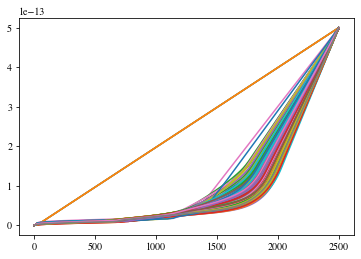

In [381]:
ss = scaleback_y(ytrain)
for i in ss:
    plt.plot(list(range(2500)),i)

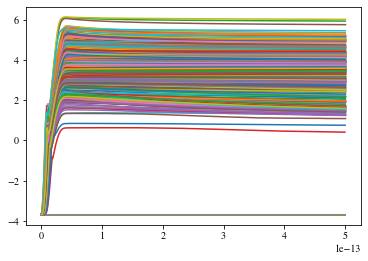

In [428]:

hf=h5py.File('/Users/harry/Documents/plugg/exjobb/files_from_davinci/database_generator4/VDB.hdf5','r')
data = [hf[key] for key in list(hf.keys()) if len(list(hf[key].keys())) == 3]
iso = [np.log(list(i['time/electron_temperature'])) for i in data]
times  = [list(i['time/time']) for i in data]

for i in list(range(len(iso))):
    plt.plot(times[i],iso[i])

In [383]:
def scale_y(y):
    return (y + np.ones(y.shape)*shift_y)/maxval_y

def scaleback_y(y):
    
    return y*maxval_y - np.ones(y.shape)*shift_y

def scaleback_X(X,mu,sigma):
    Xtest_scaled = list(X)
    return np.array([[sample[i]*(sigma[i]**0.5)+mu[i] for i in list(range(8))] for sample in Xtest_scaled]).reshape(X.shape)

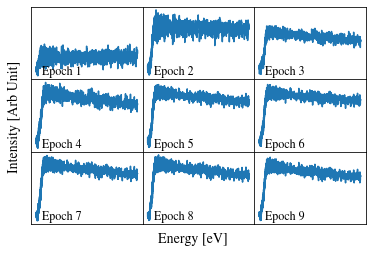

11/11 [==============================] - 0s 42ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.7621e-04 - val_mean_squared_error: 9.7621e-04 - lr: 2.0000e-06


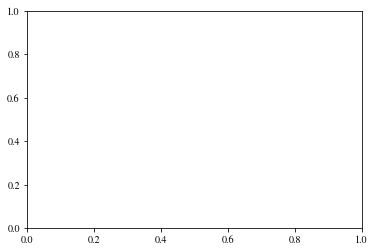

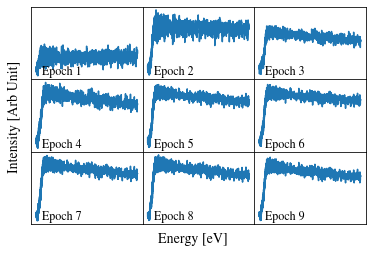

In [474]:
print(Xtrain.shape[1:])
INPUT_SHAPE = (Xtrain.shape[1:])
num_epochs = 1000
initial_lr = 0.001
final_lr = initial_lr/500
start_decay_epoch = 10
end_decay_epoch = int(num_epochs*0.9)


model = None
model = Sequential()
model.add(keras.layers.Input(shape=INPUT_SHAPE))
model.add(Dense(activation='LeakyReLU',units=16))
model.add(Dropout(0.05))
model.add(Dense(activation='LeakyReLU',units=32))
model.add(Dropout(0.05))
model.add(Dense(activation='LeakyReLU',units=64))
model.add(Dropout(0.05))
model.add(Dense(activation='LeakyReLU',units=100))
#model.add(Dense(activation='LeakyReLU',units=32))
#model.add(Dense(activation='LeakyReLU',units=32))
#model.add(Dense(activation='LeakyReLU',units=32))

#model.add(Dense(activation='LeakyReLU',units=64))                                         #dense layers
#model.add(Dense(activation='LeakyReLU',units=100))
#model.add(Dropout(0.1))
#model.add(Dense(activation='LeakyReLU',units=256))
#model.add(Dense(activation='LeakyReLU',units=512))
#model.add(Dense(activation='LeakyReLU',units=1024))
#model.add(Dense(activation='LeakyReLU',units=1048))
#model.add(Dense(activation='LeakyReLU',units=2000))
model.add(Dense(activation='linear',units=len(ytest[0])))                                             #output layer, units=dimensions of output space



    #optimizer = keras.optimizers.Adam()
def scheduler(epoch, lr):
    if epoch < start_decay_epoch:
        return lr
    if epoch >= start_decay_epoch and epoch < end_decay_epoch:
        return initial_lr -(initial_lr-final_lr)*((epoch - start_decay_epoch)/(end_decay_epoch - start_decay_epoch))
    else:
        return final_lr

model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_lr),loss="mean_squared_error", metrics = ['mean_squared_error'])
saver = CustomSaver(num_epochs,model)
#decay_lr = keras.callbacks.LearningRateScheduler(lr_Scheduler(lr_i,num_epochs))
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
print(model.summary)
herstory = model.fit(Xtrain,ytrain,batch_size=32, callbacks=[saver,lr_callback], verbose=1, epochs=num_epochs, validation_data=(Xtest, ytest)) #validation_data=(Xtest, ytest) #saver
trained_model = load_model(f'model_best_{property}.hd5')


dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])


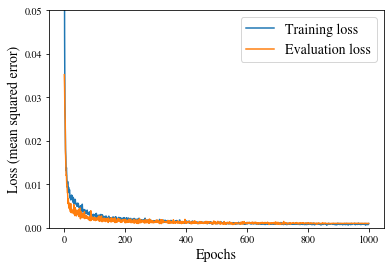

In [468]:

df2 = herstory.history
print(df2.keys())
training_loss = df2['mean_squared_error']
valuation_loss = df2['val_mean_squared_error']
epochs = list(range(0,num_epochs))
plt.clf()
plt.plot(epochs,training_loss,label='Training loss')
plt.plot(epochs,valuation_loss,label='Evaluation loss')
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Loss (mean squared error)',fontsize=14)
plt.ylim([0,0.05])
plt.legend(fontsize=14)
plt.savefig('/Users/harry/Pictures/latex_pics/loss.png')

plt.show()

2/2 [==============================] - 0s 3ms/step
   Unnamed: 0      maxval_y       shift_y
0           0  5.000777e-13  1.261474e-32
2/2 [==============================] - 0s 3ms/step


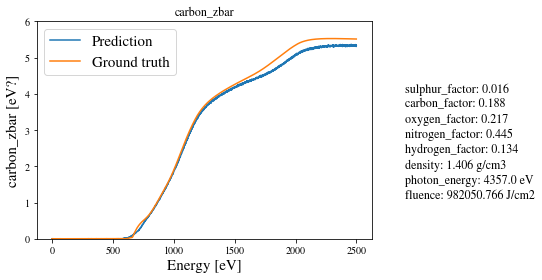

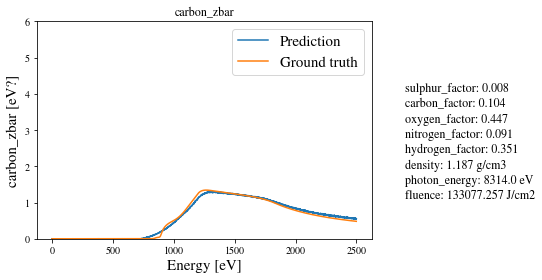

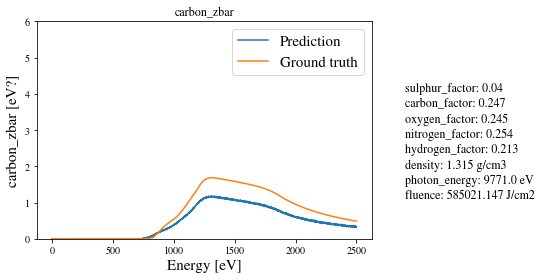

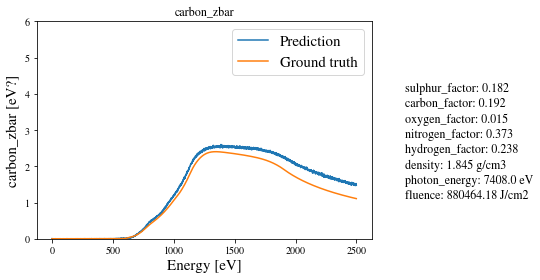

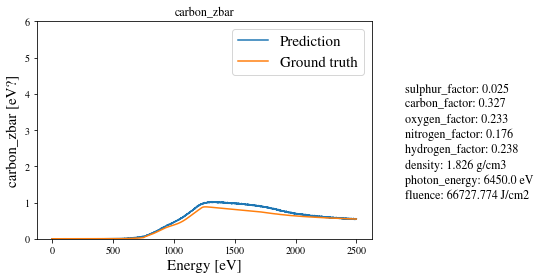

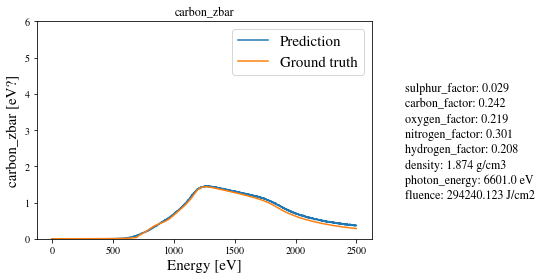

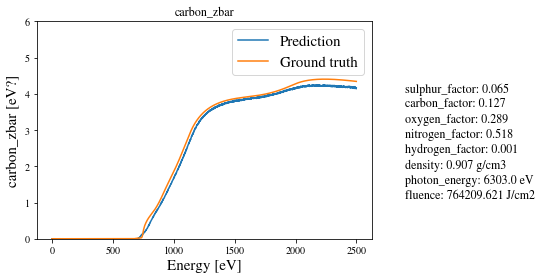

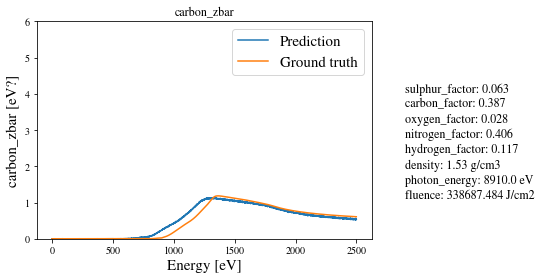

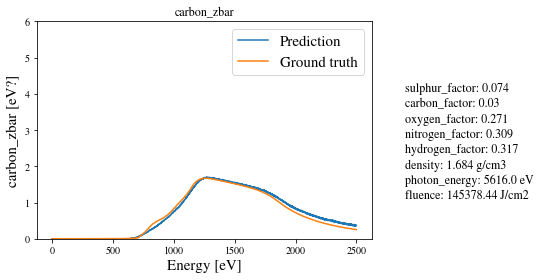

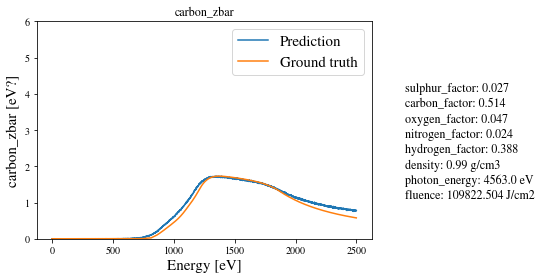

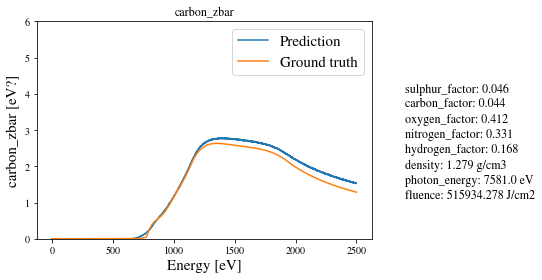

In [475]:

#N = [randint(1,30) for i in [1,2,3,4,5,6,7,8,9,0,11,12,13,14,15,16]]
N=[1,2,3,4,5,6,7,8,9,0,11]
model_t = load_model(f'model_best_time.hd5')
t = model_t.predict(Xtest)
t = scale_time(t)
model = load_model(f'model_best_{property}.hd5')
pred = scaleback_y(model.predict(Xtest))
ground_truth = scaleback_y(ytest)
input_values = scaleback_X(Xtest,mu,sigma)
label_names = ['fluence','photon_energy','density','hydrogen_factor','nitrogen_factor','oxygen_factor','carbon_factor','sulphur_factor']
label_units = ['J/cm2','eV','g/cm3',' ',' ',' ',' ',' ']
for n in N:

    fig,ax=plt.subplots()
#    ax.set_xscale('log')
    ax.plot(list(range(2500)),pred[n],label='Prediction')
    ax.plot(list(range(2500)),ground_truth[n],label='Ground truth')
    ax.set_xlabel('Energy [eV]',fontsize=15)
    ax.set_ylabel(f'{property} [eV?]',fontsize=15)
    ax.set_ylim([0,6])
    ax.set_title(f'{property}')

    for j in list(range(len(label_names))):
        ax.text(1.1, 0.2 + (j*0.07), f'{label_names[j]}: {round(input_values[n,j],3)} {label_units[j]}',fontsize=12,                                             
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.legend(fontsize=15)


In [417]:
def scale_input_time(X):
    scalings = pd.read_csv('/Users/harry/Documents/plugg/exjobb/skript/javascript/web_application/weights/scalings_input_time.csv')
    mu = list(scalings['mu'])
    sigma = list(scalings['sigma'])
    length = len(X)    
    return [(X[prop] - mu[prop])/sigma[prop]**0.5 for prop in list(range(length))]
    
def scale_time(y):
    scalings = pd.read_csv('/Users/harry/Documents/plugg/exjobb/skript/javascript/web_application/weights/scalings_output_time.csv')
    print(scalings)
    maxval_y = float(scalings['maxval_y'])
    shift_y = float(scalings['shift_y'])        

    retur =  y*maxval_y - np.ones(y.shape)*shift_y
    return retur

1/1 [==============================] - 0s 43ms/step


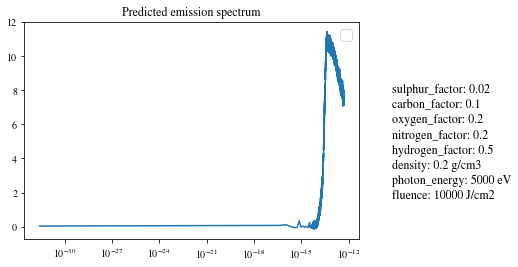

In [76]:
def plot_prediction(fluence,photon_energy,density,hydrogen,nitrogen,oxygen,carbon,sulphur,trained_model):
    scaled_inputs = make_input(fluence,photon_energy,density,hydrogen,nitrogen,oxygen,carbon,sulphur)
    input = np.array([fluence,photon_energy,density,hydrogen,nitrogen,oxygen,carbon,sulphur]).reshape(1,8)
    prediction = model.predict(scaled_inputs)
    fig,ax = plt.subplots()
    ax.set_xscale('log')
    plt.plot(E,scaleback_y(prediction).reshape(E.shape))
    plt.title('Predicted emission spectrum')
    label_names = ['fluence','photon_energy','density','hydrogen_factor','nitrogen_factor','oxygen_factor','carbon_factor','sulphur_factor']
    
    for j in list(range(len(label_names))):
        ax.text(1.1, 0.2 + (j*0.07), f'{label_names[j]}: {inputs[j]} {label_units[j]}',fontsize=12,
                                                      
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.legend(fontsize=15)

fluence = 10000
photon_energy = 5000
density = 0.2
hydrogen = 0.5
nitrogen = 0.2
oxygen = 0.2
carbon = 0.1
sulphur=0.02

inputs = [fluence,photon_energy,density,hydrogen,nitrogen,oxygen,carbon,sulphur]

plot_prediction(fluence,photon_energy,density,hydrogen,nitrogen,oxygen,carbon,sulphur,trained_model=trained_model)

In [27]:
def make_input(fluence,photon_energy,density,hydrogen,nitrogen,oxygen,carbon,sulphur):
    s = sum([hydrogen,nitrogen,oxygen,carbon,sulphur])
    hydrogen,nitrogen,oxygen,carbon,sulphur = (hydrogen/s,nitrogen/s,oxygen/s,carbon,sulphur/s)
    return  scale_X(np.array([fluence,photon_energy,density,hydrogen,nitrogen,oxygen,carbon,sulphur]).reshape(1,8))

In [476]:
model = load_model(f'model_best_{property}.hd5')
W = model.get_weights()
for i in list(range(len(W))):
# convert array into dataframe
    DF = pd.DataFrame(W[i])
# save the dataframe as a csv file
    DF.to_csv(f'/Users/harry/Documents/plugg/exjobb/skript/javascript/web_application/weights/{property}_model_weights/{property}_model_{lex[i]}.csv')

In [408]:
lex = {0:'W1',1:'b1',2:'W2',3:'b2',4:'W3',5:'b3',6:'W4',7:'b4',8:'W5',9:'b5',10:'W6',11:'b6',12:'W7',13:'b7',14:'W8',15:'b8'}


In [409]:
t = Em
df = pd.DataFrame(t,columns=['time [fs]'])
df.to_csv(f'/Users/harry/Documents/plugg/exjobb/skript/javascript/web_application/weights/time_values.csv')

In [477]:
scalings = [mu,sigma]
 
df = pd.DataFrame(
    {'mu': mu, 'sigma': sigma})
df.columns = ['mu', 'sigma']
print(df)
df.to_csv(f'/Users/harry/Documents/plugg/exjobb/skript/javascript/web_application/weights/scalings_input_{property}.csv')

              mu         sigma
0  407192.181202  9.497049e+10
1    5879.894286  5.465901e+06
2       1.288497  1.816435e-01
3       0.236212  1.694942e-02
4       0.235769  1.881715e-02
5       0.234123  1.739243e-02
6       0.246892  1.636514e-02
7       0.047004  1.065398e-03


In [478]:
scalings = [[maxval_y],[shift_y]]
df = pd.DataFrame(
    {'maxval_y': scalings[0], 'shift_y': scalings[1]})
df.columns = ['maxval_y', 'shift_y']
print(df)
df.to_csv(f'/Users/harry/Documents/plugg/exjobb/skript/javascript/web_application/weights/scalings_output_{property}.csv')

   maxval_y       shift_y
0  5.843164  2.271936e-85


In [328]:
print(mu)
print(sigma)

[4.35113743e+05 6.36638889e+03 1.28961301e+00 2.46747979e-01
 2.42094559e-01 2.21451183e-01 2.42879178e-01 4.68271012e-02]
[8.76117114e+10 4.75778798e+06 1.90296383e-01 1.64910761e-02
 1.82115812e-02 1.57065968e-02 1.67452741e-02 8.83106429e-04]


In [128]:
N =2500
hf=h5py.File('/Users/harry/Documents/plugg/exjobb/files_from_davinci/database_generator1/VDB.hdf5','r')
keys = list(hf.keys())
print(keys)
e = [list(hf[f'/{key}/time/time']) for key in keys if (len(hf[key])==3)]
Z = [(N)/len(j) for j in e] #interpolators. Interpolate two extra indices, which we will trim away to reduce risk of edge effects
E_int = [interpolation.zoom(e[j],Z[j]) for j in list(range(len(e)))]


Em = [np.mean([E_int[i][j] for i in list(range(len(E_int)))]) for j in list(range(2500))]
Em = np.array(Em)


['data_1', 'data_10', 'data_100', 'data_101', 'data_102', 'data_103', 'data_104', 'data_105', 'data_106', 'data_107', 'data_108', 'data_109', 'data_11', 'data_110', 'data_111', 'data_112', 'data_113', 'data_114', 'data_115', 'data_116', 'data_117', 'data_118', 'data_119', 'data_12', 'data_120', 'data_121', 'data_122', 'data_123', 'data_124', 'data_125', 'data_126', 'data_127', 'data_128', 'data_129', 'data_13', 'data_130', 'data_131', 'data_132', 'data_133', 'data_134', 'data_135', 'data_136', 'data_137', 'data_138', 'data_139', 'data_14', 'data_140', 'data_141', 'data_142', 'data_143', 'data_144', 'data_145', 'data_146', 'data_147', 'data_148', 'data_149', 'data_15', 'data_150', 'data_151', 'data_152', 'data_153', 'data_154', 'data_155', 'data_156', 'data_157', 'data_158', 'data_159', 'data_16', 'data_160', 'data_161', 'data_162', 'data_163', 'data_164', 'data_165', 'data_166', 'data_167', 'data_168', 'data_169', 'data_17', 'data_170', 'data_171', 'data_172', 'data_173', 'data_174', '

<ipython-input-128-e74611813da3>:7: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  E_int = [interpolation.zoom(E[j],Z[j]) for j in list(range(len(E)))]


1/1 [==============================] - 0s 27ms/step
(2500,)
(1, 2500)


ValueError: x and y must have same first dimension, but have shapes (1933,) and (2500,)

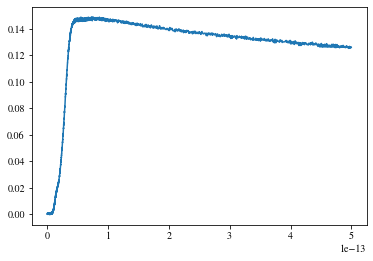

In [134]:
y = model.predict(np.array([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]).reshape(1,8))
print(Em.shape)
print(y.shape)
plt.plot(Em,y.reshape(Em.shape))
plt.plot(np.array(E[0]),y.reshape(y.shape[1],))

In [141]:
times = np.array(pd.read_csv('https://raw.githubusercontent.com/agelii92/exjobb/main/weights/time_values.csv'))[:,1]
print(times)

[2.22032318e-32 4.43732511e-17 1.28045035e-16 ... 4.99268803e-13
 5.00013352e-13 4.48026923e-13]


In [249]:
hf=h5py.File('/Users/harry/Documents/plugg/exjobb/files_from_davinci/database_generator1/VDB.hdf5','r')
spectra = [filter_peak(np.log(np.array(list(hf[f'/data_{i}/spectrum_energy/spectrum'])))) for i in [16,2,3,52,26]]
E = np.array(list(hf['/data_1/spectrum_energy/spectrum_energy']))
t = np.array(pd.read_csv('https://raw.githubusercontent.com/agelii92/exjobb/main/weights/time_values.csv'))[:,1]

elec_temps = [np.array(list(hf[f'/data_{i}/time/electron_temperature'])) for i in [16,2,3,52,26]]
ionization =  [np.array(list(hf[f'/data_{i}/time/total_zbar'])) for i in [16,2,3,52,26]]

n = 2500 #interpolate so that time depentend property has 2500 time steps
Z = [(n+2)/len(j) for j in elec_temps] #interpolators. Interpolate two extra indices, which we will trim away to reduce risk of edge effects
elec_temps = [interpolation.zoom(elec_temps[j],Z[j])[0:n] for j in list(range(len(elec_temps)))]

Z = [(n+2)/len(j) for j in ionization] #interpolators. Interpolate two extra indices, which we will trim away to reduce risk of edge effects
ionization = [interpolation.zoom(ionization[j],Z[j])[0:n] for j in list(range(len(ionization)))]

<ipython-input-249-e0e821d74898>:11: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  elec_temps = [interpolation.zoom(elec_temps[j],Z[j])[0:n] for j in list(range(len(elec_temps)))]
<ipython-input-249-e0e821d74898>:14: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  ionization = [interpolation.zoom(ionization[j],Z[j])[0:n] for j in list(range(len(ionization)))]


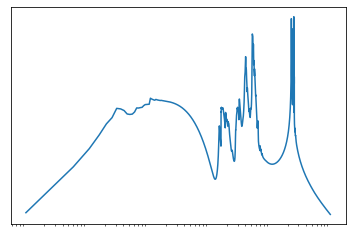

In [279]:
fig,ax = plt.subplots()
ax.set_xscale('log')
ax.set_yticks([])
ax.set_xticks([])
#ax.set_ylabel('Intensity [Arb. unit]',fontsize=15)
#ax.set_xlabel('Energy [eV]',fontsize=15)
ax.plot(E,spectra[4])


Text(0.5, 0, 'Time [s]')

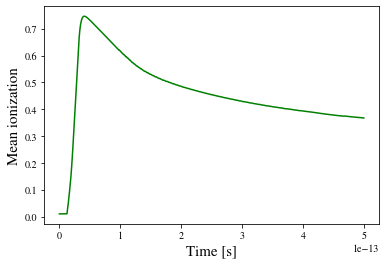

In [274]:
fig,ax=plt.subplots()
ax.plot(t,ionization[4],color='green')
ax.set_ylabel('Mean ionization',fontsize=15)
ax.set_xlabel('Time [s]',fontsize=15)

Text(0.5, 0, 'Time [s]')

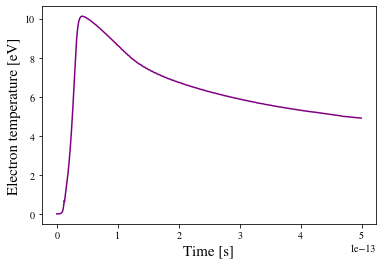

In [278]:
fig,ax=plt.subplots()
ax.plot(t,elec_temps[4],color='purple')
ax.set_ylabel('Electron temperature [eV]',fontsize=15)
ax.set_xlabel('Time [s]',fontsize=15)